In [1]:
import fastf1
import fastf1.plotting
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from openpyxl.styles import PatternFill
from openpyxl import Workbook
from openpyxl import load_workbook
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm
from scipy.interpolate import make_interp_spline
from fastf1 import utils
from statistics import mean 
from scipy import stats

# enabling misc_mpl_mods will turn on minor grid lines that clutters the plot
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False)

In [2]:
ses = 5
race = 18

In [3]:
session = fastf1.get_session(2023,race,ses)
session.load()
fastf1.Cache.enable_cache('cache') 

req         WARNING 	

DEFAULT CACHE ENABLED!
	Cache directory: C:\Users\GTR\AppData\Local\Temp\fastf1.
	Size: 344.3 MB


core           INFO 	Loading data for United States Grand Prix - Race [v3.1.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core        WARNING 	Session results contain duplicate entries for driver(s) ['22']
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '55', '11', '63', '10', '18', '22', '23', '2', '27', '77', '24', '20', '3', '1

In [4]:
session_Sprint = fastf1.get_session(2023,race,4)
session_Sprint.load()
fastf1.Cache.enable_cache('cache')

core           INFO 	Loading data for United States Grand Prix - Sprint [v3.1.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '16', '4', '11', '55', '10', '63', '23', '81', '31', '3', '14', '22', '27', '77', '24', '20', '2', '18']


### Pre defined

In [5]:
def Safety_car(df):
    """Extracts intervals from a DataFrame and adds +1 to the second couple if the two elements are equal.

    Args:
        df: A DataFrame containing the data to extract intervals from.

    Returns:
        A list of intervals, where each interval is a tuple of (start, end).
    """

    # Initialize the list of intervals
    intervals = []

    # Iterate over the rows in the DataFrame
    for i in range(len(df)):

        # Check if the current row is the start of a new interval
        if i == 0 or df.iloc[i, 0] != df.iloc[i - 1, 0] + 1:

            # Add the new interval to the list
            intervals.append([df.iloc[i, 0],df.iloc[i, 0]])

        # Update the end of the current interval
        intervals[-1] = (intervals[-1][0], df.iloc[i, 0])

    # Loop over the intervals and check if the couples of intervals need +1 for the second couple
    for i in range(len(intervals)):
        if intervals[i][0] == intervals[i][1]:
            # Convert the interval tuple to a list
            interval_list = list(intervals[i])

            # Update the value of the second element in the list
            interval_list[1] = interval_list[1] + 1

            # Convert the list back to a tuple
            intervals[i] = tuple(interval_list)

    return intervals
# Set display options to show all columns
pd.set_option('display.max_columns', None)

def calculate_delta_times(df_lap, df_reference):
    """Calculates the delta times for a given lap, relative to a reference lap.

    Args:
    lap_data: A numpy array containing the lap data. The lap data should be in the
        form of a 2D array, where the first column is the distance and the second
        column is the time.
    reference_lap_data: A numpy array containing the reference lap data. The
        reference lap data should be in the same format as the lap data.

    Returns:
    A numpy array containing the delta times.
    """
    # # Add attribute TimeS to the dataframe
    df_lap["TimeS"] = df_lap["Time"].dt.total_seconds()
    df_reference["TimeS"] = df_reference["Time"].dt.total_seconds()

    # # Stretch or contract the distances across all the data objects so that the total
    # # distance of the lap matches the fastest (reference) lap in the selection.
    df_lap["Distance"] = df_lap["Distance"] * (df_reference.iloc[-1]["Distance"] / df_lap.iloc[-1]["Distance"])
    # Use linear interpolation to align each data object with the data objects in
    # the fastest lap.

    interp_lap_data = np.interp(df_lap["Distance"], df_reference["Distance"],df_reference["TimeS"])
    # Return the difference in time at each instance.
    delta_times =  interp_lap_data.tolist() - df_lap["TimeS"]

    return delta_times, df_lap["Distance"]

def SectorDistance(laps):

    sector_time = []
    sector_distance = []
    lap = laps.pick_fastest()
    for i in range(3):
        sector_time.append(lap["Sector"+str(i+1)+"Time"])
    for i in range(2):
        sector_time[i+1] = sector_time[i] + sector_time[i+1]
    lap_telemetry = lap.get_telemetry()
    sector_distance.append(lap_telemetry.loc[lap_telemetry["Time"] <= sector_time[0],"Distance"].max())
    sector_distance.append(lap_telemetry.loc[lap_telemetry["Time"] <= sector_time[1],"Distance"].max())
    sector_distance.append(lap_telemetry["Distance"].max())
    return sector_distance
    
def SectorLocation(laps):

    sector_location = [[],[]]
    sector_distance = SectorDistance(laps)
    comp = laps.pick_fastest().get_telemetry()
    comp = comp [["X","Y","Distance"]]
    for i in sector_distance:
        Sec = comp
        Sec["MinDis"] = (Sec["Distance"] - i).abs()
        sec_loc = Sec.loc[Sec["MinDis"]==Sec["MinDis"].min(),["X","Y"]].values[0]
        sector_location[0].append(sec_loc[0]) # Append X
        sector_location[1].append(sec_loc[1]) # Append Y
    return sector_location

In [6]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

compoundcolor = pd.DataFrame.from_dict(
    {
        1: ['HARD','#F0F0EC'], 
        2:['INTERMEDIATE', '#43B02A'], 
        3:['MEDIUM','#FFD12E'], 
        4:['SOFT', '#DA291C'], 
        5:['TEST-UNKNOWN', '#434649'], 
        6:['UNKNOWN','#00FFFF'], 
        7:['WET', '#0067AD']
    },
    orient='index',
    columns=['Compound', 'CompoundColor']
)

In [34]:
# getting laps of session
laps = session.laps 

# Cleaning laps data
a = laps[(laps['LapTime'].isna())&(laps['LapNumber'] != 1)&(laps['Sector1Time'].notna())] 
a["LapTime"] = a["Sector1Time"] + a["Sector2Time"] + a["Sector3Time"]
laps[(laps['LapTime'].isna())&(laps['LapNumber'] != 1)&(laps['Sector1Time'].notna())] = a

# adding lap time in seconds
laps['LapTimeS'] = laps["LapTime"].dt.total_seconds()

# adding lap time start in seconds
laps['LapStartTimeS'] = laps["LapStartTime"].dt.total_seconds()

# adding lap time finish in seconds
laps['LapFinishTimeS'] = laps["LapStartTimeS"] + laps["LapTimeS"]

# adding lap time end in seconds
laps['DeltaTime'] = 0 # add column Delta time filled with 0

# adding missing data to first lap
laps.loc[laps["LapNumber"] == 1,['LapFinishTimeS']] = laps.loc[laps["LapNumber"] == 2,["LapStartTimeS"]].values

# getting max lap of session
max_lap_race = int(session.laps["LapNumber"].max())

#results of race
results = session.results
results = results.sort_values(by=['Position'])

#correcting team color
results["TeamColor"] = [fastf1.plotting.team_color(i) for i in results["TeamName"]] 

# drivers list
drivers = results["DriverNumber"].values
# drivers =['1', '81', '4', '63', '16', '14', '31', '77', '24', '11', '18', '10', '23', '20', '22', '27', '40', '2', '44']

# Drivers Start order 
drivers_start = results[["DriverNumber","GridPosition"]].sort_values(by=['GridPosition'])
drivers_start = drivers_start["DriverNumber"].values

#drivers abreviation
drivers_abr = [session.get_driver(driver)["Abbreviation"] for driver in drivers]

# Drivers Start order 
drivers_start_abr = results[["Abbreviation","GridPosition"]].sort_values(by=['GridPosition'])
drivers_start_abr = drivers_start_abr["Abbreviation"].values

#race name 
race_name = session.event["EventName"]
session_name = session.event["Session"+str(ses)]
corners_distance = session.get_circuit_info().corners
sector_distance = SectorDistance(laps)
sector_location = SectorLocation(laps)

In [8]:
# getting laps_s of session
laps_s = session_Sprint.laps

# Cleaning laps_s data
a = laps_s[(laps_s['LapTime'].isna())&(laps_s['LapNumber'] != 1)&(laps_s['Sector1Time'].notna())] 
a["LapTime"] = a["Sector1Time"] + a["Sector2Time"] + a["Sector3Time"]
laps_s[(laps_s['LapTime'].isna())&(laps_s['LapNumber'] != 1)&(laps_s['Sector1Time'].notna())] = a

# adding lap time in seconds
laps_s['LapTimeS'] = laps_s["LapTime"].dt.total_seconds()

# adding lap time start in seconds
laps_s['LapStartTimeS'] = laps_s["LapStartTime"].dt.total_seconds()

# adding lap time finish in seconds
laps_s['LapFinishTimeS'] = laps_s["LapStartTimeS"] + laps_s["LapTimeS"]

# adding lap time end in seconds
laps_s['DeltaTime'] = 0 # add column Delta time filled with 0

# adding missing data to first lap
laps_s.loc[laps_s["LapNumber"] == 1,['LapFinishTimeS']] = laps_s.loc[laps_s["LapNumber"] == 2,["LapStartTimeS"]].values


In [9]:
DRIVERS = []
for i in range(1,max_lap_race+1):
    lap = laps.loc[laps["LapNumber"]== max_lap_race+1-i].sort_values(by=["LapFinishTimeS"],ascending=True).reset_index(drop=True)
    for j in range(0,len(lap)):
        if lap.iloc[j]["DriverNumber"] not in DRIVERS:
            DRIVERS.append(lap.iloc[j]["DriverNumber"] )


In [35]:
if((DRIVERS == drivers.tolist())):
    print("same order")
else:
    DRV = pd.DataFrame()
    DRV["DriverNumber"] = DRIVERS
    results = pd.merge(DRV, results, on='DriverNumber')
    # drivers list
    drivers = results["DriverNumber"].values

    # Drivers Start order 
    drivers_start = results[["DriverNumber","GridPosition"]].sort_values(by=['GridPosition'])
    drivers_start = drivers_start["DriverNumber"].values

    #drivers abreviation
    drivers_abr = [session.get_driver(driver)["Abbreviation"] for driver in drivers]

    # Drivers Start order 
    drivers_start_abr = results[["Abbreviation","GridPosition"]].sort_values(by=['GridPosition'])
    drivers_start_abr = drivers_start_abr["Abbreviation"].values
    print("The list was reorganized")


The list was reorganized


Telemetry

In [53]:
telemetry.loc[(telemetry["Distance"]> 2000) & (telemetry["Distance"]< 3000)]

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Distance,RelativeDistance,Status,X,Y,Z
252,2023-10-21 22:20:56.117,0 days 01:11:57.596000,,NaN,0 days 00:00:34.672000,10221,194,4,100,False,0,pos,2000.600308,0.368636,OnTrack,11985,2880,1516
253,2023-10-21 22:20:56.211,0 days 01:11:57.690000,,NaN,0 days 00:00:34.766000,10415,198,5,100,False,0,car,2005.821111,0.369598,OnTrack,12032,2891,1516
254,2023-10-21 22:20:56.397,0 days 01:11:57.876000,,NaN,0 days 00:00:34.952000,10586,200,5,100,False,0,pos,2016.245391,0.371519,OnTrack,12102,2910,1516
255,2023-10-21 22:20:56.411,0 days 01:11:57.890000,,NaN,0 days 00:00:34.966000,10757,202,5,100,False,0,car,2017.043333,0.371666,OnTrack,12107,2911,1515
256,2023-10-21 22:20:56.731,0 days 01:11:58.210000,,NaN,0 days 00:00:35.286000,10957,212,5,100,False,0,car,2035.887778,0.375138,OnTrack,12278,2955,1514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,2023-10-21 22:21:13.537,0 days 01:12:15.016000,,NaN,0 days 00:00:52.092000,10782,270,7,100,False,0,pos,2941.515874,0.542012,OnTrack,11497,5293,1381
388,2023-10-21 22:21:13.731,0 days 01:12:15.210000,,NaN,0 days 00:00:52.286000,10825,271,7,100,False,0,car,2956.140278,0.544706,OnTrack,11410,5270,1382
389,2023-10-21 22:21:13.857,0 days 01:12:15.336000,,NaN,0 days 00:00:52.412000,10865,272,7,100,False,0,pos,2965.703115,0.546468,OnTrack,11350,5256,1383
390,2023-10-21 22:21:13.971,0 days 01:12:15.450000,,NaN,0 days 00:00:52.526000,10906,274,7,100,False,0,car,2974.406944,0.548072,OnTrack,11247,5230,1383


In [96]:
driver = ['1', '1']
laps_driver = []
lap_i_driver = []
telemetry_driver = []
team_driver = []
delta_time = []
lap_race_number = [48 ,11]
max_delta_time = 0
distance_min = 3500
distance_max = 4000
corners = corners_distance.loc[(corners_distance["Distance"]> distance_min) & (corners_distance["Distance"]< distance_max)].reset_index(drop=True)

laps_driver.append(laps.pick_driver(driver[0]))
lap_i_driver.append(laps_driver[0].pick_lap(lap_race_number[0]))
telemetry = lap_i_driver[0].get_telemetry()
telemetry = telemetry.loc[(telemetry["Distance"]> distance_min) & (telemetry["Distance"]< distance_max)]
telemetry_driver.append(telemetry)
team_driver.append(lap_i_driver[0]['Team'])

laps_driver.append(laps_s.pick_driver(driver[1]))
lap_i_driver.append(laps_driver[1].pick_lap(lap_race_number[1]))
telemetry = lap_i_driver[1].get_telemetry()
telemetry = telemetry.loc[(telemetry["Distance"]> distance_min) & (telemetry["Distance"]< distance_max)]
telemetry_driver.append(telemetry)
team_driver.append("yellow")

team_color = [fastf1.plotting.team_color(session.get_driver(driver[0])["TeamName"]),"yellow"]

for i in range(1,len(driver)):
    delta_time1, Distance  = calculate_delta_times(telemetry_driver[0], telemetry_driver[i])
    if (max_delta_time < delta_time1.max()):
        max_delta_time = delta_time1.max()
    delta_time.append(delta_time1)

0.02476515999358213


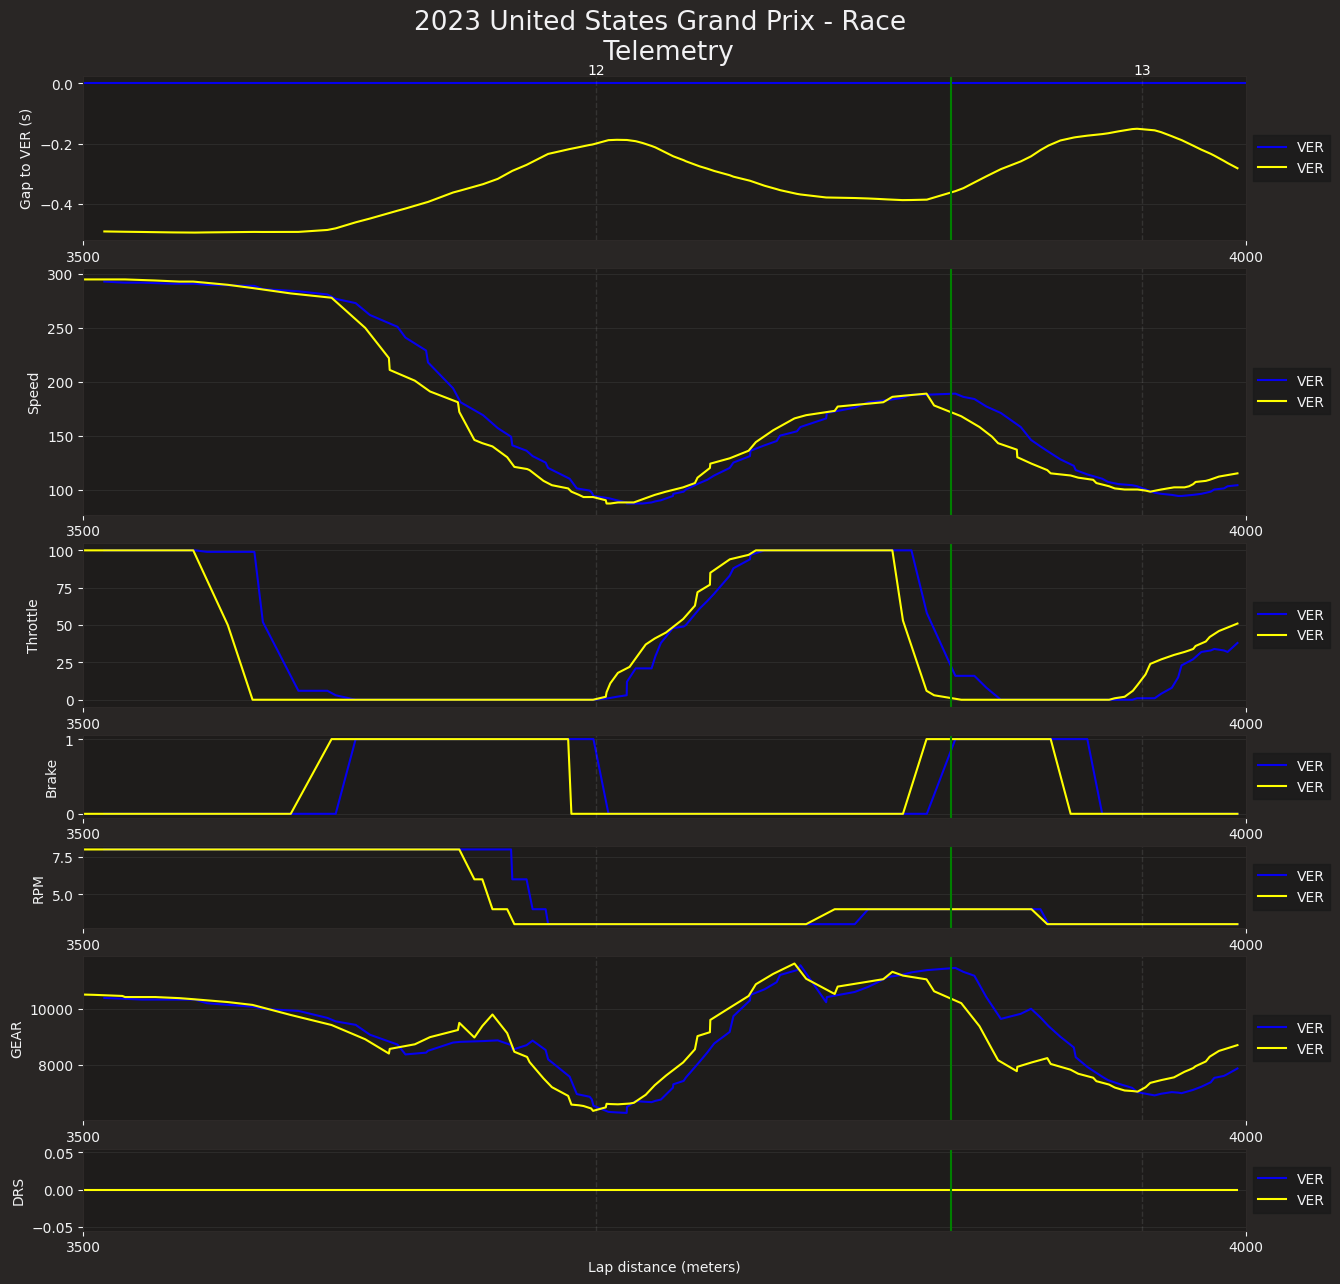

In [99]:

# plt.style.use("cyberpunk")
plot_size = [15, 15]
plot_title = f"{session.event.year} {session.event.EventName} - {session.name} \n Telemetry"
plot_ratios = [ 2, 3, 2, 1, 1, 2, 1]

# Make plot a bit bigger
plt.rcParams['figure.figsize'] = plot_size

# Create subplots with different sizes
fig, ax = plt.subplots(7, gridspec_kw={'height_ratios': plot_ratios})

#Delta line
ax[0].axhline(0,label=session.get_driver(driver[0])['Abbreviation'], color=team_color[0])
# Delta time to first driver
for i in range(0,len(driver)-1):
    ax[0].plot(Distance, delta_time[i], label=session.get_driver(driver[i+1])['Abbreviation'], color=team_color[1])
# ploting other graphes
for i in range(0,len(driver)):
    ax[1].plot(telemetry_driver[i]['Distance'], telemetry_driver[i]['Speed'], label=session.get_driver(driver[i])['Abbreviation'], color=team_color[i])
    ax[2].plot(telemetry_driver[i]['Distance'], telemetry_driver[i]['Throttle'], label=session.get_driver(driver[i])['Abbreviation'], color=team_color[i])
    ax[3].plot(telemetry_driver[i]['Distance'], telemetry_driver[i]['Brake'], label=session.get_driver(driver[i])['Abbreviation'], color=team_color[i])
    ax[4].plot(telemetry_driver[i]['Distance'], telemetry_driver[i]['nGear'], label=session.get_driver(driver[i])['Abbreviation'], color=team_color[i])
    ax[5].plot(telemetry_driver[i]['Distance'], telemetry_driver[i]['RPM'], label=session.get_driver(driver[i])['Abbreviation'], color=team_color[i])
    ax[6].plot(telemetry_driver[i]['Distance'], telemetry_driver[i]['DRS'], label=session.get_driver(driver[i])['Abbreviation'], color=team_color[i])

# Set the plot title
ax[0].title.set_text(plot_title)
ax[0].set(ylabel=f"Gap to {session.get_driver(driver[0])['Abbreviation']} (s)")
ax[1].set(ylabel='Speed')
ax[1].legend(loc="lower right")
ax[2].set(ylabel='Throttle')
ax[3].set(ylabel='Brake')
ax[4].set(ylabel='RPM')
ax[5].set(ylabel='GEAR')
ax[6].set(ylabel='DRS')
ax[6].set(xlabel='Lap distance (meters)')


# Hide x labels and tick labels for top plots and y ticks for right plots.
# for a in ax.flat:
#     a.label_outer()
for i in range(0,7):
    ax[i].grid(axis = 'y',alpha = 0.1)
    ax[i].set_xticks(range(0, 8000, 500)) 
    ax[i].set_xlim(distance_min, distance_max)
    ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[i].axvline(x=sector_distance[0], color='green', linestyle='-')
    ax[i].axvline(x=sector_distance[1], color='green', linestyle='-')
    for j in range(0,len(corners_distance)):
        ax[i].axvline(x=corners_distance['Distance'][j], color='white', linestyle='--', linewidth=1, alpha=0.1)

highest_y_value = ax[0].get_ylim()[1]
print(highest_y_value)

for j in range(0,len(corners)):
    ax[0].text(corners['Distance'][j],highest_y_value+0.02,str(corners['Number'][j]), ha='center', va='center',color='white')

    
# Store figure
plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/Telemetry'+session.event["Session"+str(ses)]+'.png', dpi=300, bbox_inches='tight')
plt.show()